In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [60]:
# Load the CIFAR-10 dataset
(features_train_full, label_train_full), (features_test, label_test) = cifar10.load_data()

In [61]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

The 10 classes of the cifar10 dataset are:


1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck


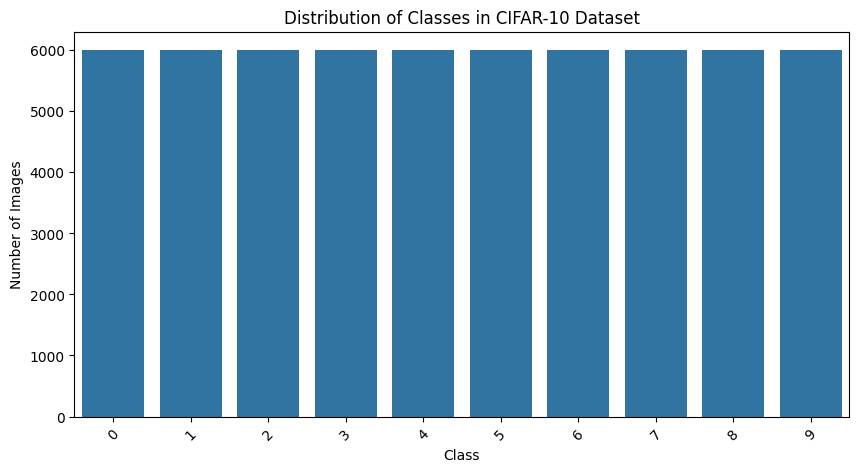

In [62]:
# Combine training and testing labels for visualization
all_labels = np.concatenate((label_train_full, label_test))

# Count the number of elements in each category
label_counts = pd.Series(all_labels.flatten()).value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in CIFAR-10 Dataset')
plt.xticks(rotation=45)
plt.show()

The dataset is well balanced, with each class having roughly the same number of images (around 6,000 each). This ensures equal representation across categories, minimizing bias and supporting better model performance across all classes.

In [63]:
# Splitting the data set into test and validation sets
features_train_val, features_test, label_train_val, label_test = train_test_split(
    features_train, label_train, test_size=0.2, random_state=42
)
features_train, features_val, label_train, label_val = train_test_split(
    features_train_val, label_train_val, test_size=0.25, random_state=42
)

print(f"Shape of Training Features: {features_train.shape}")
print(f"Shape of Validation Features: {features_val.shape}")
print(f"Shape of Test Features: {features_test.shape}")
print(f"Shape of Training Labels: {label_train.shape}")
print(f"Shape of Validation Labels: {label_val.shape}")
print(f"Shape of Test Labels: {label_test.shape}")

print(f"Size of the Training Data: {features_train.size}")  # 60% training data
print(f"Size of the Validation Data: {features_val.size}")  # 20% validation data
print(f"Size of the Test Data: {features_test.size}")  # 20% test data

Shape of Training Features: (8100, 32, 32, 3)
Shape of Validation Features: (2700, 32, 32, 3)
Shape of Test Features: (2700, 32, 32, 3)
Shape of Training Labels: (8100, 1)
Shape of Validation Labels: (2700, 1)
Shape of Test Labels: (2700, 1)
Size of the Training Data: 24883200
Size of the Validation Data: 8294400
Size of the Test Data: 8294400


In [64]:
# Training generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # A moderate range for rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow(features_train, label_train, batch_size=64)
val_generator = val_test_datagen.flow(features_val, label_val, batch_size=64)
test_generator = val_test_datagen.flow(features_test, label_test, batch_size=64)

In [65]:
# Improved custom CNN model with more layers and regularization
model_cnn = Sequential([
    Input(shape=(32, 32, 3)),  
    
    # First convolutional block: Conv2D -> BatchNorm -> MaxPooling
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Second convolutional block: Conv2D -> BatchNorm -> MaxPooling
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Third convolutional block: Conv2D -> BatchNorm -> MaxPooling
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Flatten the feature maps before passing to dense layers
    Flatten(),
    
    # Fully connected layer with 512 neurons, ReLU activation, BatchNorm and Dropout
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer with 10 neurons for CIFAR-10 classes and softmax activation
    Dense(10, activation='softmax')
])

# Print a summary of the model
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [66]:
# Compile the model with Adam optimizer, lower learning rate, and accuracy metric
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [67]:
# Train the model with the train and validation generators
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=len(features_train) // 64,
    epochs=5, 
    validation_data=val_generator,
    validation_steps=len(features_val) // 64
)

Epoch 1/5
126/126 [==============================] - 7s 53ms/step - loss: 2.6212 - accuracy: 0.1052 - val_loss: 2.5458 - val_accuracy: 0.0000e+00
Epoch 2/5
126/126 [==============================] - 8s 61ms/step - loss: 2.1787 - accuracy: 0.1002 - val_loss: 2.5739 - val_accuracy: 0.0833
Epoch 3/5
126/126 [==============================] - 4s 35ms/step - loss: 2.0002 - accuracy: 0.0984 - val_loss: 2.2544 - val_accuracy: 0.0956
Epoch 4/5
126/126 [==============================] - 5s 36ms/step - loss: 1.9000 - accuracy: 0.0968 - val_loss: 1.6682 - val_accuracy: 0.1120
Epoch 5/5
126/126 [==============================] - 5s 37ms/step - loss: 1.7846 - accuracy: 0.0969 - val_loss: 1.4425 - val_accuracy: 0.1562


In [68]:
# Loading the base model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
base_model.trainable = False

In [69]:
# Transfer learning model using VGG16
model_transfer = Sequential([
    Input(shape=(32, 32, 3)),
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Print a summary of the transfer learning model
model_transfer.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [70]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
# Compile the transfer learning model
model_transfer.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [71]:
# Train the transfer learning model
history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=len(features_train) // 64,
    epochs=5,  
    validation_data=val_generator,
    validation_steps=len(features_val) // 64
)

Epoch 1/5
126/126 [==============================] - 17s 130ms/step - loss: 2.2714 - accuracy: 0.0747 - val_loss: 1.9978 - val_accuracy: 0.1057
Epoch 2/5
126/126 [==============================] - 14s 112ms/step - loss: 2.0169 - accuracy: 0.1038 - val_loss: 1.8121 - val_accuracy: 0.0997
Epoch 3/5
126/126 [==============================] - 14s 115ms/step - loss: 1.8691 - accuracy: 0.1074 - val_loss: 1.6943 - val_accuracy: 0.1135
Epoch 4/5
126/126 [==============================] - 16s 127ms/step - loss: 1.7903 - accuracy: 0.1050 - val_loss: 1.6326 - val_accuracy: 0.1153
Epoch 5/5
126/126 [==============================] - 16s 123ms/step - loss: 1.7302 - accuracy: 0.1017 - val_loss: 1.5749 - val_accuracy: 0.1008


In [72]:
# Evaluate the transfer learning model on the test set
test_loss_transfer, test_accuracy_transfer = model_transfer.evaluate(test_generator, steps=len(features_test) // 64)
print(f"Transfer Learning Testing Accuracy: {test_accuracy_transfer:.4f}")

42/42 [==============================] - 4s 84ms/step - loss: 1.5760 - accuracy: 0.1023
Transfer Learning Testing Accuracy: 0.1023


In [73]:
# Custom CNN Model Training and Validation Accuracy
cnn_train_acc = history_cnn.history['accuracy']
cnn_val_acc = history_cnn.history['val_accuracy']

print(f"Custom CNN - Final Training Accuracy: {cnn_train_acc[-1]:.4f}")
print(f"Custom CNN - Final Validation Accuracy: {cnn_val_acc[-1]:.4f}")

# Transfer Learning Model Training and Validation Accuracy
transfer_train_acc = history_transfer.history['accuracy']
transfer_val_acc = history_transfer.history['val_accuracy']

print(f"Transfer Learning - Final Training Accuracy: {transfer_train_acc[-1]:.4f}")
print(f"Transfer Learning - Final Validation Accuracy: {transfer_val_acc[-1]:.4f}")

Custom CNN - Final Training Accuracy: 0.0969
Custom CNN - Final Validation Accuracy: 0.1562
Transfer Learning - Final Training Accuracy: 0.1017
Transfer Learning - Final Validation Accuracy: 0.1008


42/42 [==============================] - 0s 7ms/step - loss: 1.4244 - accuracy: 0.1574
Custom CNN Testing Accuracy: 0.1574
42/42 [==============================] - 0s 7ms/step


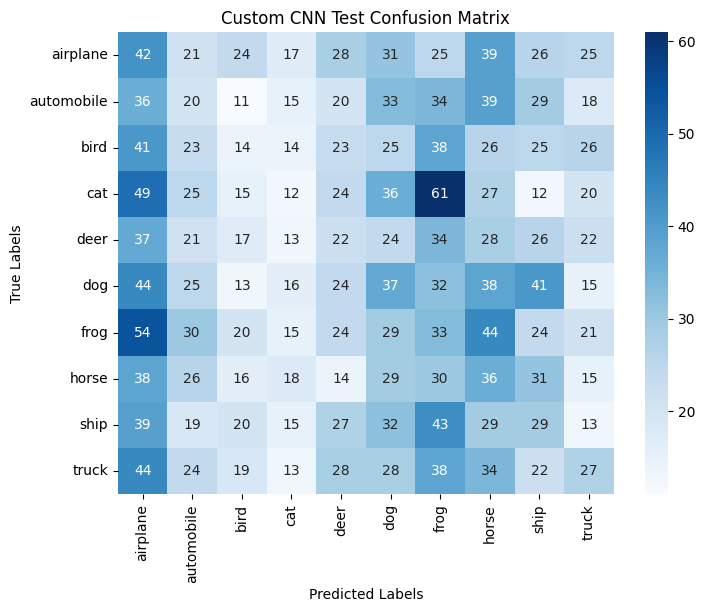

In [74]:
# Evaluate the custom CNN model on the test data using the generator
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_generator, steps=len(features_test) // 64)
print(f"Custom CNN Testing Accuracy: {test_accuracy_cnn:.4f}")

# Generate predictions on the test set using the generator
test_predictions_cnn = model_cnn.predict(test_generator, steps=len(features_test) // 64)
test_predictions_cnn = np.argmax(test_predictions_cnn, axis=1)

# Confusion matrix for the test data
test_confusion_matrix_cnn = confusion_matrix(label_test[:len(test_predictions_cnn)], test_predictions_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Custom CNN Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 224ms/step

Class: airplane


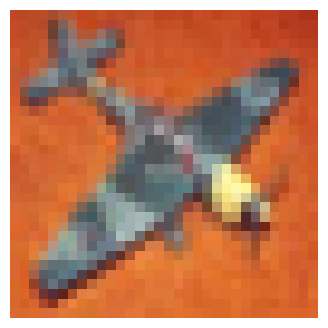

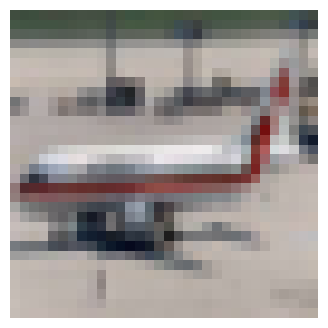

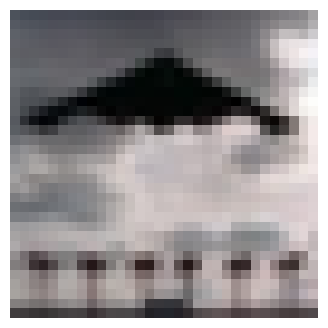

1/1 [==============================] - 0s 65ms/step

Class: automobile


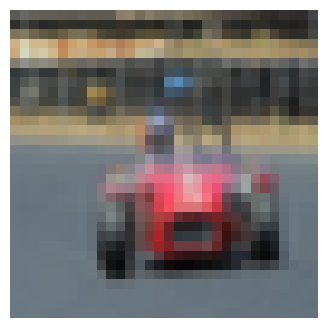

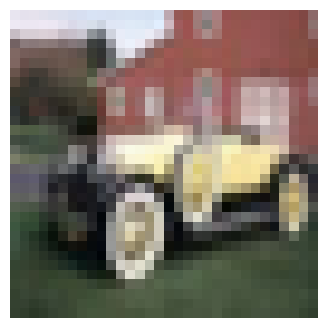

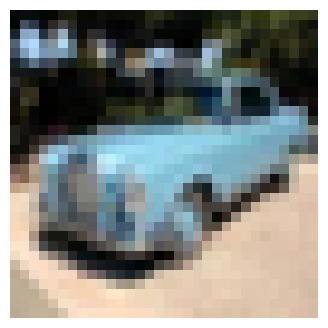

1/1 [==============================] - 0s 60ms/step

Class: bird


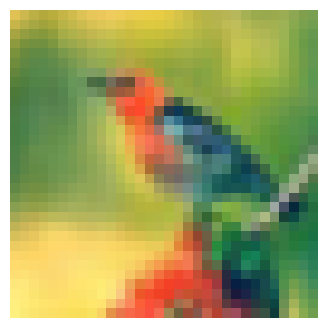

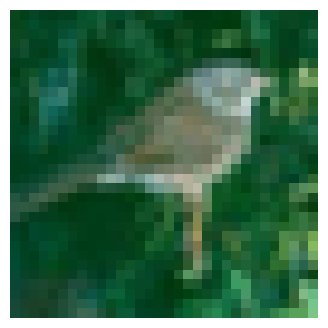

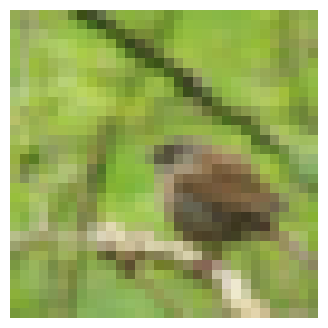

1/1 [==============================] - 0s 43ms/step

Class: cat


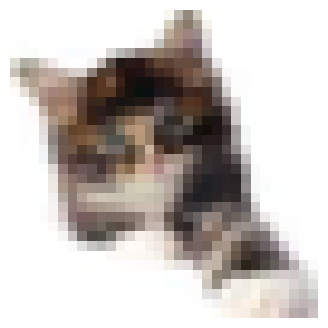

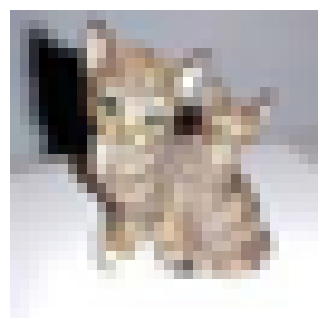

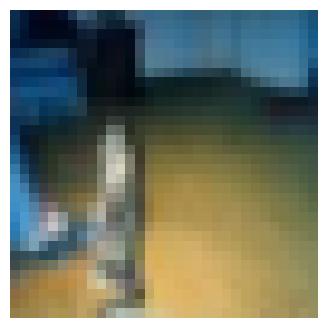

1/1 [==============================] - 0s 41ms/step

Class: deer


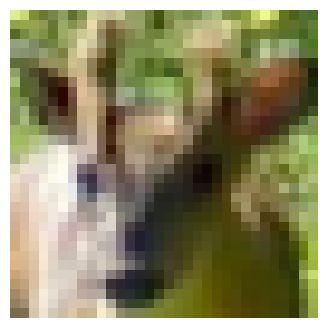

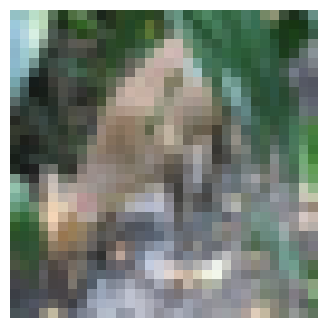

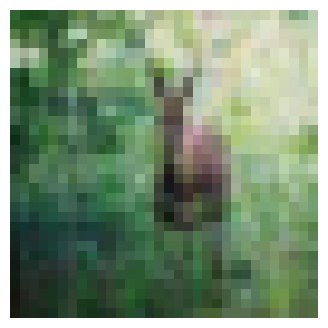

1/1 [==============================] - 0s 63ms/step

Class: dog


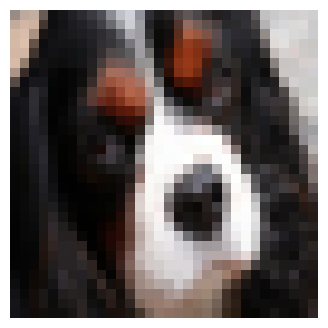

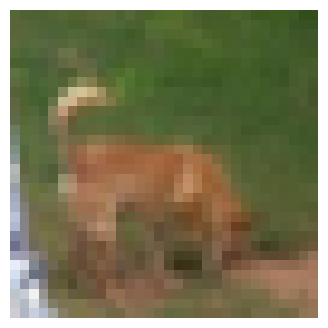

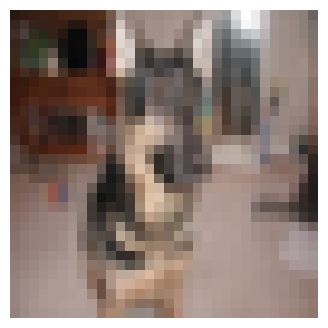

1/1 [==============================] - 0s 42ms/step

Class: frog


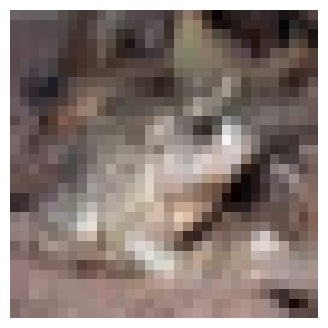

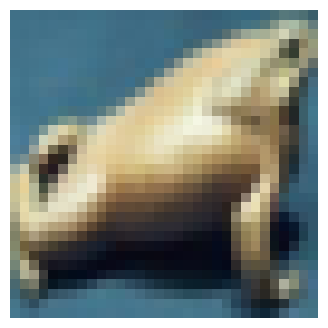

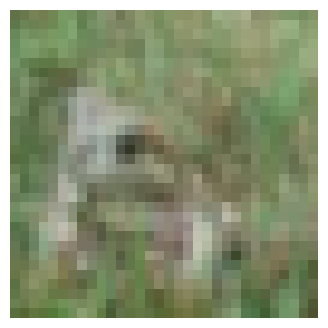

1/1 [==============================] - 0s 41ms/step

Class: horse


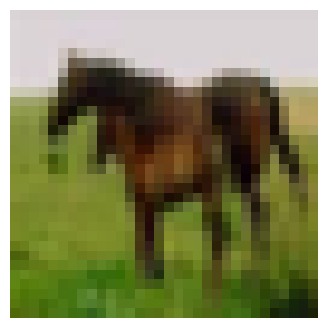

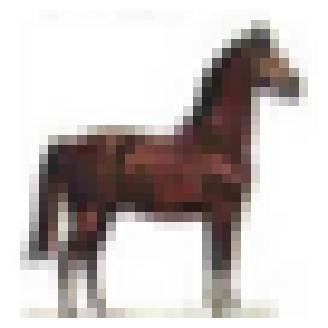

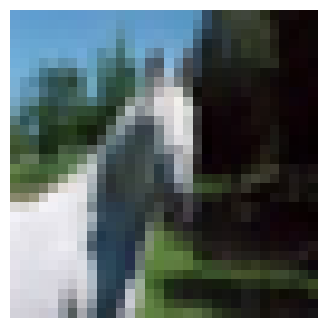

1/1 [==============================] - 0s 42ms/step

Class: ship


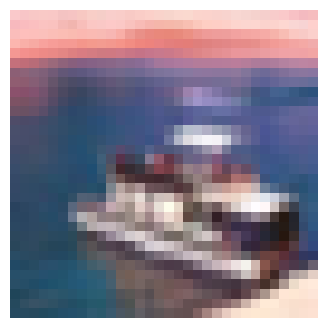

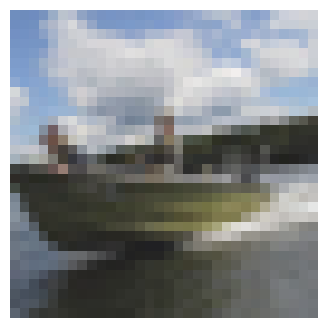

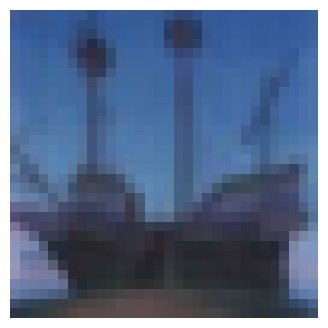

1/1 [==============================] - 0s 40ms/step

Class: truck


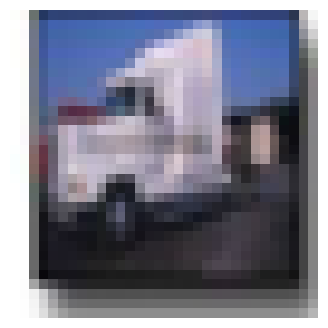

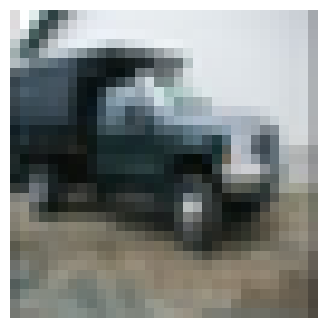

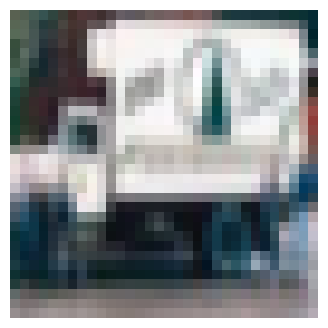

In [75]:
# Loop over each class name in the CIFAR-10 dataset
for class_name in class_names:
    # Get the index of the current class
    class_index = class_names.index(class_name)
    
    # Find all indices of the current class in the test set
    class_indices = np.where(label_test.flatten() == class_index)[0]
    
    # Randomly select 3 indices from the current class
    sample_indices = np.random.choice(class_indices, 3, replace=False)
    
    # Select the 3 images and their labels
    sample_images = features_test[sample_indices]
    sample_labels = label_test[sample_indices]
    
    # Preprocess the images to match the model's input format
    sample_images = sample_images.astype('float32') / 255.0
    
    # Make predictions on the selected images using the transfer learning model
    predictions = model_transfer.predict(sample_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Print and display results for the current class
    print(f"\nClass: {class_name}")
    for i in range(len(sample_images)):
        plt.figure(figsize=(4, 4))  # Set the figure size small to avoid stretching
        plt.imshow(sample_images[i])  # Display the image as is
        plt.axis('off')
        plt.show()
